<a href="https://colab.research.google.com/github/bonnie-w/nma-project/blob/main/NMA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mimicking Human Image Similarity Judgment Using Siamese Neural Network

  **By:** Bonnie, You, Bereket, Melika
  

# Introduction

Humans have the ability to make similarity judgments about objects. These judgments are formed through hierarchical categorization of core criterias of the objects such as color, shape, purpose, etc. Our project trains a neural network model that can capture the core dimensions used by humans to judge similarity between objects and apply it to recognizing the “odd one out” in a set of triplet natural images.

Our idea was motivated by a [NIH paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7666026/#R17) that showed human object similarity can be recreated through using embedding matrix with a modeling algorithm. In our implementation we hope to achieve the same objective but instead using a neural network.

#Objective

**Research Question:** Can we mimic human visual similarity judgment using a neural network that can learn representations from images used in odd-one-out tasks?

**Hypothesis:** We hypothesize that the neural network will perform to a level close to humans in identifying odd-out images and the learned representations will not be affected by noise and geometric variations introduced to the input images.

## Set Up

In [1]:
# @title Import necessary libraries
# import os
# import cv2
# import re
# import glob
# import imageio
# import random, shutil
# import torch
# import torch.nn as nn
# from tqdm.notebook import tqdm
# import torch.nn.functional as F
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import scipy.io
# import IPython.display as display
# import librosa
# import librosa.display
# from PIL import Image
# from __future__ import print_function
# import argparse, random, copy
# import torch.optim as optim
# import torchvision
# from torch.utils.data import Dataset
# from torchvision import datasets
# from torchvision import transforms as T
# from torch.optim.lr_scheduler import StepLR
from __future__ import print_function
import os
import json
import cv2
import re
import glob
import random, shutil
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import IPython.display as display
import librosa
import librosa.display
from PIL import Image
import argparse, random, copy
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [ ]:
# Connect to your own google drive
from google.colab import drive
drive.mount('/content/drive')

# Add the shared folder to your own drive
# sharing link: https://drive.google.com/drive/folders/1x3tdfgPkzZ73JvPHsmwApbs_eIRMxgGe?usp=drive_link
%cd /content/drive/MyDrive/NMA_Project/

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/MyDrive/NMA_Project/'
/content


## Download the Dataset

In [ ]:
# Download the dataset to Google Drive

import requests

def unzipdata(fname,dname,password):
  if fname.lower().endswith('.zip'):
    if password:
      !unzip -P {password} {fname} -d {dname} > /dev/null 2>&1
    else:
      !unzip {fname} -d {dname} > /dev/null 2>&1
    print("Successfully unzip {} !".format(fname))
  else:
    !mv {fname} {dname}


def downloaddata(fname,url):
  '''
  fname: filename of the data to be downloaded
  url: URL for the data
  '''
  try:
    # sends a GET request
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download {} !!!".format(fname))
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download {} !!!".format(fname))
    else:
      # download the file
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print("Successfully downloaded {} !".format(fname))


fnames = ["full_triplet_dataset.zip","sortind.mat","unique_id.txt",
          "object_images_A-C.zip","object_images_D-K.zip""object_images_L-Q.zip","object_images_R-S.zip","object_images_T-Z.zip"]
urls = ["https://osf.io/n9u4a/download","https://osf.io/52e7c/download","https://osf.io/7zuah/download",
        "https://osf.io/6kzat/download","https://osf.io/whm5p/download","https://osf.io/ay8mv/download","https://osf.io/qm6gh/download","https://osf.io/c2spb/download"]
dnames = ["triplet_dataset","variables/sortind.mat","variables/unique_id.txt","Images",
          "Images","Images","Images","Images"]
passwords = ["","","","things4all","things4all","things4all","things4all","things4all"]

for i in range(len(fnames)):
  # check if the data has existed
  if not (os.path.isfile(dnames[i]) or os.path.isdir(dnames[i])):
    downloaddata(fnames[i],urls[i])
    unzipdata(fnames[i],dnames[i],passwords[i])
  else:
    print('{} already exists.'.format(dnames[i]))
  print()



Successfully downloaded full_triplet_dataset.zip !
Successfully unzip full_triplet_dataset.zip !

Successfully downloaded sortind.mat !
mv: cannot move 'sortind.mat' to 'variables/sortind.mat': No such file or directory

Successfully downloaded unique_id.txt !
mv: cannot move 'unique_id.txt' to 'variables/unique_id.txt': No such file or directory

Successfully downloaded object_images_A-C.zip !
Successfully unzip object_images_A-C.zip !

Images already exists.

Images already exists.

Images already exists.



## Load the Data

**Triplet dataset**

All derived data are triplets recoded to 0 base (i.e. everything minus 1), and resorted
to have the chosen pair first, followed by the odd one out at the end. For example, if
the triplet was [1001 593 203] and the odd-one-out choice was 1001, then it will be [593 203 1001].
* **trainset.txt** (n = 4120663 ): 90% of regular data
* **validationset.txt** (n = 453642): 10% of regular data, sampled every 10+/5 triplets (i.e. since a HIT is
     20 triplets, around 18 for training and 2 for test)
* **testset1.txt** (n = 15640): Noise ceiling triplets (1000 repeatedly sampled triplets), used for original dataset
* **testset2.txt** (n = 36406): Separate set of noise ceiling triplets but primarily from early trials within a HIT
* **testset2_repeat.txt** (n = 36408): Same triplets repeated within subject in the same HIT.
* **testset3.txt** (n = 36401): Much larger set of between-subject repeats of the same 1000 triplets.


See more in triplet_datasets/dataset_description.txt

In [ ]:
# resort triplet dataset
triplet_fnames = ['trainset','testset1','testset2','testset2_repeat','testset3','validationset']
sortind = scipy.io.loadmat('variables/sortind.mat')['sortind'].squeeze()
sortind -= 1 # from 0
for triplet_fname in triplet_fnames:
  if not os.path.isfile('triplet_dataset/'+triplet_fname+'_resorted.txt'):
    triplet_file = np.loadtxt('triplet_dataset/'+triplet_fname+'.txt')
    for i_obj in tqdm(range(1854)):
      triplet_file[triplet_file==sortind[i_obj]] = 10000+i_obj
    triplet_file = triplet_file-10000
    np.savetxt('triplet_dataset/'+triplet_fname+'_resorted.txt',triplet_file)

FileNotFoundError: [Errno 2] No such file or directory: 'variables/sortind.mat'

Then, we loaded each set of train, test, and validation triplet sets into separate txt files.

In [ ]:
# load the triplet dataset
train_triplets = np.loadtxt('triplet_dataset/train_triplets.txt').astype(np.int64)
validation_triplets = np.loadtxt('triplet_dataset/validation_triplets.txt').astype(np.int64)
test_triplets = np.loadtxt('triplet_dataset/test_triplets.txt').astype(np.int64)

**Image dataset**

The 1,854 images of objects are the *reference images* in the THINGS database, each representing a single different natural image, sorted by alphabetical order. The triplet images are obtained according to the indices given  in the txt files.

All images chosen from ImageNet were labeled with the letter n. All reference images were labeled with the letter b, and all other images with the letter s.

In [ ]:
def find_ref_image(root_folder):

  ref_image_name = [] # reference images
  obj_cpt_name = [] # object concept

  for subdir, _, files in os.walk(root_folder):

    obj = os.path.basename(subdir)
    for file in files:
      if re.search('_01b.*.jpg',file):
        # Add the file to the dictionary under the appropriate subdirectory name
        ref_image_name.append(file)
        obj_cpt_name.append(obj)
        # Break after finding the first matching file in the subdirectory
        break

  return ref_image_name,obj_cpt_name

root_folder = 'Images'
output_folder = 'object_images'

if not os.path.isdir(output_folder):

  # find 1854 obeject images used in the behavioral task.
  ref_image_name,obj_cpt_name = find_ref_image(root_folder)

  unique_id = np.array(pd.read_csv('variables/unique_id.txt',header = None)).squeeze()

  # create a new folder to contain 1854 images
  !mkdir {output_folder}
  for img_i in tqdm(range(len(ref_image_name))):
    ind = str(np.where(unique_id == obj_cpt_name[img_i])[0][0]).rjust(4,'0')
    !cp {root_folder}/{obj_cpt_name[img_i]}/{ref_image_name[img_i]} {output_folder}/{ind}_{ref_image_name[img_i]}


In [ ]:
# load image dataset
img_size = 200
images_data = np.zeros([1854,img_size,img_size,3],dtype = np.uint8)
imagelist = sorted(os.listdir('object_images'))
imageind = np.array([int(x[:4]) for x in imagelist])
for img_i in tqdm(range(len(imagelist))):
  filename = imagelist[np.where(imageind==img_i)[0][0]]
  image = np.array(Image.open('object_images/'+filename))
  if image.shape[0] != img_size:
    images_data[img_i,:,:,:] = cv2.resize(image,[img_size,img_size])
  else:
    images_data[img_i,:,:,:] = image

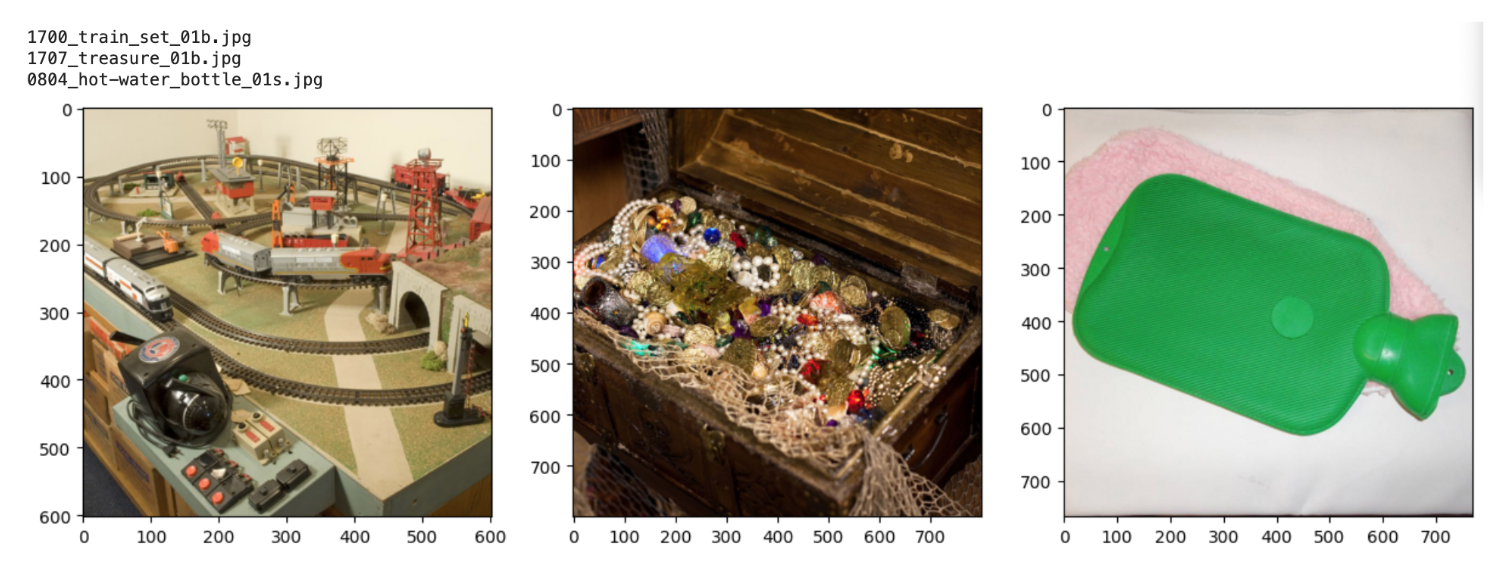

## Visualization of the Dataset

A random triplet sample is selected from the training triplet_dataset and displayed below. The right-most image is labeled as the odd-one-out.

In [ ]:
# visualize triplet sample with image indices [1700, 1707, 804]
sample_set = train_triplets[5]
plt.figure(figsize=(20, 5))

for i in range(len(sample_set)):
  plt.subplot(1, 4, i + 1)
  filename = imagelist[int(sample_set[i])]
  print(filename)
  plt.imshow(np.array(Image.open('object_images/' + filename)))

# The Siamese Model

Our model aims to input three images and then identify  the one that differs from the others. We fine-tuned a pre-trained ResNet18 to extract features from the images.

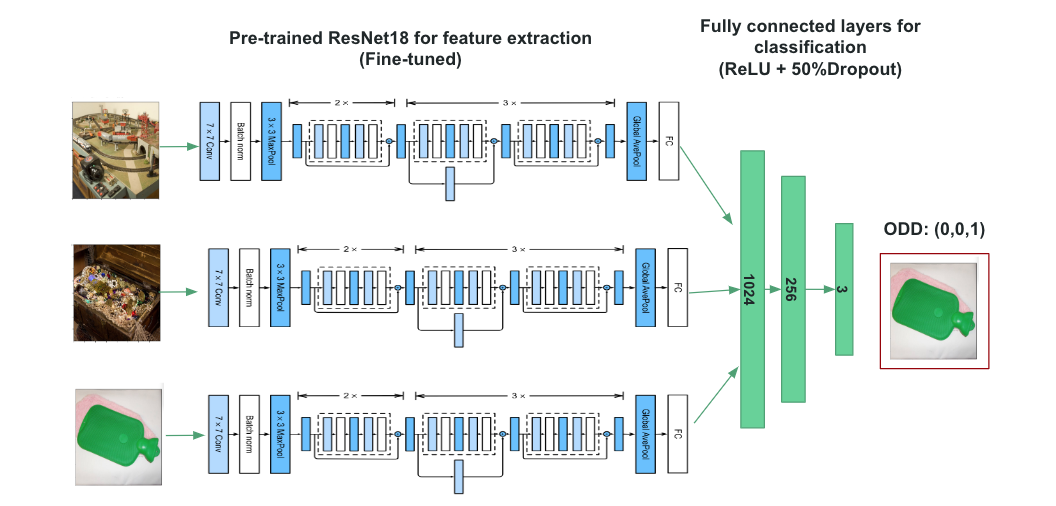

In [ ]:
class TripletDataset(Dataset):
    def __init__(self, image_matrix, triplets):
        """
        Args:
            image_matrix (numpy array): The matrix of images with shape (1854, 800, 800, 3).
            triplets (numpy array): The triplets of image indices with shape (n_triplets, 3).
        """
        self.image_matrix = image_matrix
        self.triplets = triplets
        self.imageTransform = transforms.Compose([transforms.ToPILImage(),
                                                  transforms.Resize(256),
                                                  transforms.CenterCrop(224),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                       std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        idx_1, idx_2, idx_3 = self.triplets[idx]
        img_1 = self.image_matrix[idx_1]
        img_2 = self.image_matrix[idx_2]
        img_3 = self.image_matrix[idx_3]

        # Convert to torch tensors
        img_1 = torch.tensor(img_1, dtype=torch.float32).permute(2, 0, 1)  # (3, 800, 800)
        img_2 = torch.tensor(img_2, dtype=torch.float32).permute(2, 0, 1)
        img_3 = torch.tensor(img_3, dtype=torch.float32).permute(2, 0, 1)

        # Transform
        img_1 = self.imageTransform(img_1)
        img_2 = self.imageTransform(img_2)
        img_3 = self.imageTransform(img_3)

        # set the label
        target = torch.tensor([0,0,1], dtype=torch.float)

        # shuffle the index of odd image
        random_idx = torch.randperm(3)
        target= target[random_idx]
        image_temp = torch.concat([img_1.unsqueeze(0),img_2.unsqueeze(0),img_3.unsqueeze(0)],dim=0)
        img_1,img_2,img_3 = tuple([image_temp[x] for x in random_idx])

        return img_1, img_2, img_3, target

The feature vectors for three images are concatenated and passed through fully connected layers, using ReLU activations and 50% Dropout. The output is processed by a Softmax layer to classify the odd image.

In [ ]:
class Triplet(nn.Module):
    # fine tune resnet

    def __init__(self):
        super(Triplet, self).__init__()

        # get resnet model
        self.resnet = torchvision.models.resnet18(pretrained=True)


        # add additional linear layers to compare between the features of the three images
        self.fc = nn.Sequential(
            nn.Linear(1000*3, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),   # Add dropout to prevent overfitting
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),   # Add dropout to prevent overfitting
            nn.Linear(256, 3)
        )

        self.softmax = nn.Softmax(dim=1)

        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)

        output = torch.cat([output1, output2, output3], dim=1)
        output = self.fc(output)
        output = self.softmax(output)

        return output

**Training the Model**

Our model was trained using binary cross-entropy loss and L2 regularization, with a learning rate of 0.0001 and early stopping to prevent overfitting. We chose a subset of the dataset for training and evaluation. The training results show that our model's accuracy on the validation set stabilizes around 56%, while on the training set, it continues to improve, indicating some overfitting.

In [ ]:
def train(model,device,train_loader,optimizer,epoch,dry_run=False):
  model.train() # switch to training mode
  train_loss = 0
  train_correct = 0
  total = 0

  criterion = nn.BCELoss()
  for batch_idx, (images_1,images_2,images_3,targets) in enumerate(train_loader):
    images_1,images_2,images_3,targets = images_1.to(device),images_2.to(device),images_3.to(device),targets.to(device)
    optimizer.zero_grad()
    outputs = model(images_1,images_2,images_3).squeeze()
    loss = criterion(outputs,targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.sum().item() # sum up the loss in the batch
    total += targets.size(0)
    pred = torch.zeros_like(outputs) # num_batch X 3
    pred.scatter_(1,torch.argmax(outputs,dim=1).unsqueeze(1),1) #set 1 at the index of  max probablity
    train_correct += torch.all(pred == targets.view_as(pred), dim=1).sum().item()

    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f} | Accuracy: {}/{} ({:.3f}%)'.format(
          epoch,batch_idx*len(images_1),len(train_loader.dataset),
          100.*batch_idx/len(train_loader), train_loss/total,
          train_correct, total, 100.*train_correct/total))
    if dry_run:
        break

  train_loss /= len(train_loader.dataset)
  train_correct /= len(train_loader.dataset)

  return train_loss, train_correct

**Testing the Model**

In [ ]:
# @title Test Function

def test(model,device,test_loader, return_loss = False):
  model.eval() # switch to testing  mode
  test_loss = 0
  correct =0

  criterion = nn.BCELoss()

  with torch.no_grad():
    for (images_1,images_2,images_3,targets) in test_loader:
      images_1,images_2,images_3,targets = images_1.to(device),images_2.to(device),images_3.to(device),targets.to(device)
      outputs = model(images_1,images_2,images_3).squeeze()
      test_loss += criterion(outputs,targets).sum().item() # sum up the loss in the batch
      pred = torch.zeros_like(outputs) # num_batch X 3, need to check
      pred[torch.argmax(outputs,dim=1)]=1 # NEED TO CHECK, set 1 at the index of  max probablity
      correct += pred.eq(targets.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
  # using default settings. After completing the 10th epoch, the average
  # loss is 0.0000 and the accuracy 99.5-100% using default settings.
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
  return test_loss

In [ ]:
# @title Function to Plot Results

def plot_loss_acc(train,valid,test,metric):
  plt.plot(np.arange(len(train)),train,marker='o',color='r',label='train')
  plt.plot(np.arange(len(valid)),valid,marker='o',color='b',label='valid')
  if test is not None:
    plt.plot(np.arange(len(test)),test,marker='o',color='g',label='test')
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()
  plt.show()

In [ ]:
device = torch.device("cuda")

# Hyperparameters
lr = 0.0001
epoches = 100
batch_size = 128
train_size = 50000
valid_size = 10000
test_size = 10000


# Create datasets and dataloaders
train_dataset = TripletDataset(images_data, train_triplets[:train_size])
validation_dataset = TripletDataset(images_data, validation_triplets[:valid_size])
test_dataset = TripletDataset(images_data, test_triplets[:test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


# define instance of the model class
model = Triplet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # L2

dry_run = False
train_loss,valid_loss =  [],[]
train_acc,valid_acc =  [],[]
patience = 10
wait = 0
best_acc = 0.0
best_epoch = 0

for epoch in tqdm(range(1, epoches+1), desc='Training the model'):
    curr_train_loss, curr_train_acc = train(model, device, train_loader, optimizer, epoch,dry_run = dry_run)
    train_loss.append(curr_train_loss)
    train_acc.append(curr_train_acc)

    curr_valid_loss, curr_valid_acc = test(model, device, validation_loader)
    valid_loss.append(curr_valid_loss)
    valid_acc.append(curr_valid_acc)
    if (curr_valid_acc > best_acc):
        best_acc = curr_valid_acc
        best_epoch = epoch
        wait = 0
    else:
        wait += 1

    if (wait > patience):
        print(f'Early stopped on epoch: {epoch}')
        break


    # save the model and loss & acc
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss':train_loss,
    'train_acc':train_acc,
    'valid_loss':valid_loss,
    'valid_acc':valid_acc}, 'model_v4.pth')

plot_loss_acc(train_loss,valid_loss,None,'loss')
plot_loss_acc(train_acc,valid_acc,None,'acc')

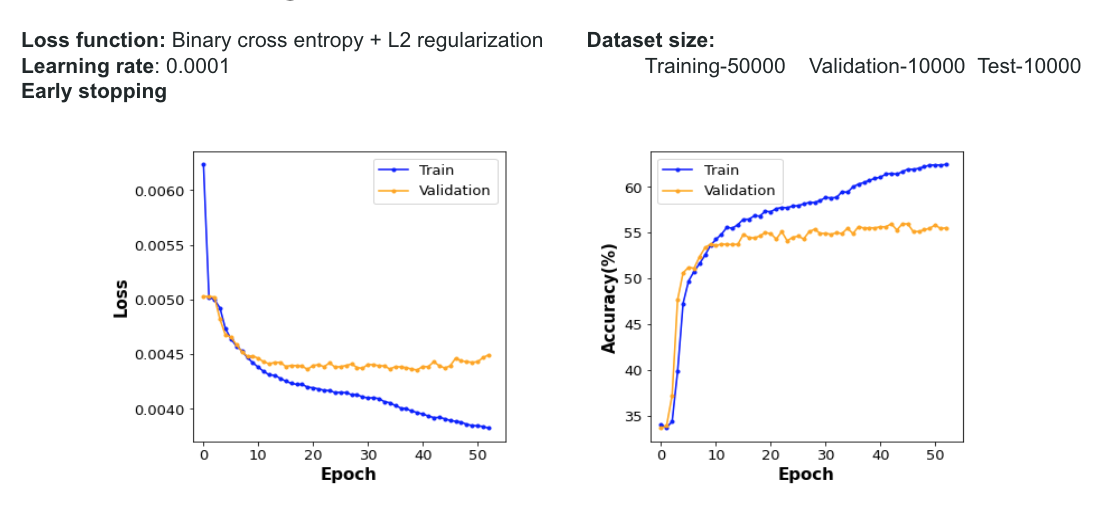

**Results in Numbers**

In [ ]:
test_dataset = TripletDataset_4(images_data, test_triplets[:test_size])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

model_4 = Triplet_4().to(device)

m4 = torch.load('model_v4.pth',map_location='cpu')
model_4.load_state_dict(m4['model_state_dict'])
test_loss, test_acc, precision, recall, f1 = test_4(model_4, device, test_loader)

print('test loss:{:6f},\ntest_acc:{:2f},\nprecision:{:2f},\nrecall:{:2f},\nf1:{:2f}'.format(test_loss, test_acc, precision, recall, f1))

**Test set:**
Average loss: 0.005606, Accuracy: 5648.0/10000 (56.480%)

* test loss:0.005606,
* test_acc:0.564800,
* precision:0.566043,
* recall:0.565279,
* f1:0.561001

# Model Evaluation

**Using Augmentations to test for Robustness**

In our initial hypothesis, we mentioned that the outcome of the training will not be affected by augmentations of the images as the neural network learning process should learn more than just the visual representation of the image. Thus, we perform random rotational, flipping, and cropping augmentations to the input images to test the training outcome.

In [ ]:
# data agumentation
data_augmentations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomRotation(30),  # rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # resize and cropping
    transforms.RandomHorizontalFlip(),  # horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # color change
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

image = images_data[1,:,:,:]

augmented_images = [data_augmentations(image) for _ in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img in enumerate(augmented_images):
    img = img.permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clip(0, 1)
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

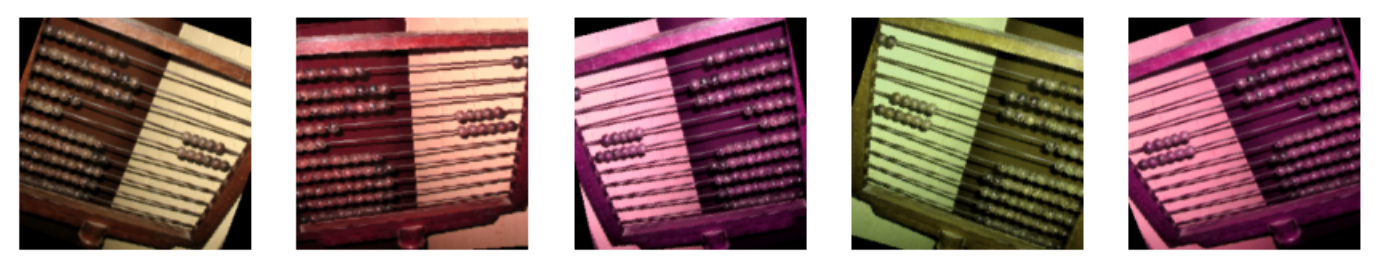

In [ ]:
class TripletDataset_4_robust(Dataset):
    def __init__(self, image_matrix, triplets, transforms):
        """
        Args:
            image_matrix (numpy array): The matrix of images with shape (1854, 800, 800, 3).
            triplets (numpy array): The triplets of image indices with shape (n_triplets, 3).
        """
        self.image_matrix = image_matrix
        self.triplets = triplets
        self.imageTransform = transforms
    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        idx_1, idx_2, idx_3 = self.triplets[idx]
        img_1 = self.image_matrix[idx_1]
        img_2 = self.image_matrix[idx_2]
        img_3 = self.image_matrix[idx_3]

        # Convert to torch tensors
        img_1 = torch.tensor(img_1, dtype=torch.float32).permute(2, 0, 1)  # (3, 800, 800)
        img_2 = torch.tensor(img_2, dtype=torch.float32).permute(2, 0, 1)
        img_3 = torch.tensor(img_3, dtype=torch.float32).permute(2, 0, 1)

        # Transform
        img_1 = self.imageTransform(img_1)
        img_2 = self.imageTransform(img_2)
        img_3 = self.imageTransform(img_3)

        # set the label
        target = torch.tensor([0,0,1], dtype=torch.float)

        # shuffle the index of odd image
        random_idx = torch.randperm(3)
        target= target[random_idx]
        image_temp = torch.concat([img_1.unsqueeze(0),img_2.unsqueeze(0),img_3.unsqueeze(0)],dim=0)
        img_1,img_2,img_3 = tuple([image_temp[x] for x in random_idx])

        return img_1, img_2, img_3, target

In [ ]:
# evaluation
model_4.eval()
correct = 0
total = 0

test_dataset_robust = TripletDataset_4_robust(images_data, test_triplets[test_size:test_size_robust+test_size], data_augmentations)
test_loader_robust = DataLoader(test_dataset_robust, batch_size=batch_size, shuffle=True, num_workers=2)

test_loss_robust, test_acc_robust, precision_robust, recall_robust, f1_robust = test_4(model_4, device, test_loader_robust)
print('test loss:{:6f},\ntest_acc:{:2f},\nprecision:{:2f},\nrecall:{:2f},\nf1:{:2f}'.format(test_loss_robust, test_acc_robust, precision_robust, recall_robust, f1_robust))

**Test set:** Average loss: 0.005917, Accuracy: 5024.0/10000 (50.240%)

* test loss:0.005917
* test_acc:0.502400
* precision:0.504004
* recall:0.503728
* f1:0.499721

# Evaluation

In [ ]:
chance_level = 33
noise_ceiling=67
prediction_accuracy = 56.48
prediction_accuracy_robust = 50.24

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15
plt.rcParams['font.weight'] = 'normal'

fig, ax = plt.subplots(figsize=(4,5))
ax.bar(0, prediction_accuracy, color='black', width=0.8)
ax.bar(1, prediction_accuracy_robust, color='black', width=0.8)

ax.plot([-0.6, 1.6], [noise_ceiling, noise_ceiling], color='gray', linewidth=10)
ax.plot([-0.6, 1.6], [chance_level, chance_level], color='green', linewidth=5)

ax.text(1.45, noise_ceiling + 1, 'Noise ceiling', ha='center', va='bottom', color='gray')
ax.text(1.45, chance_level + 0.5, 'Chance', ha='left', va='bottom', color='green')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(30, 70)
ax.set_xlim(-0.6,1.7)
ax.set_xticks([0,1])
ax.set_xticklabels(['Original','Agumented'], rotation=10,fontsize=15,fontweight='bold')
ax.set_ylabel('Prediction accuracy (%)',fontsize=17,fontweight='bold')

We can see that the accuracy of the original dataset is approximately 56%, which is higher than choosing 1 of 3 images by chance (33.33%) but lower than the noise ceiling accuracy given in the paper. When, testing the model on the augmented dataset to examine its robustness to variations, the accuracy decreases to 50.24%.

Our model partially mimics human judgment in identifying the odd image, and has robustness to variations to some extent.

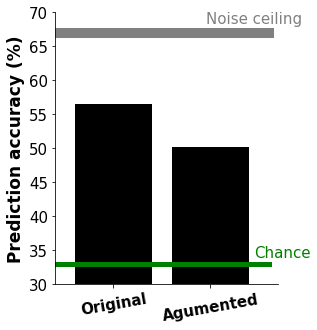

# Limitations & Future Direction

**Limitations**
* The model was trained on a small subset of the triplet dataset due to the limited available GPU.
* The embedding vectors are of high dimensions and lack interpretability.
* Embedding vectors obtained from the neural network are more biased towards visual representation instead of semantic representation.

**Possible Future Direction**
* Improving the performance of the model by training with more triplet datasets to improve the accuracy of the model (our current training only takes a very small subset of the provided training triplets).
* Convert the representations into interpretable embedding vectors.
* Incorporating semantic representation into the features learned by the neural network.